# <br>**Foundations of Deep Learning**<br/>

---

# Deep Learning for

Authors:

Princic Elisa - 886476 | Risoluti Sasha - 870667 | Torre Andrea - 886051

---

# Contents
- [Summary](#summary)
- [Virtual Machine SetUp](#setup)
- [Data Loading](#data-loading)
- [Data Exploration](#data-exploration)
  - [Plot Spectrogram](#plot-spectrogram)
  - [Descriptive Statistics](#descriptive-statistics)
- [Data Preprocessing](#data-preprocessing)
  - [Split Data in Train and Validation](#split-data-in-train-and-validation)
  - [Defining Preprocessing Function](#defining-preprocessing-function)
- [Model Definition and Training](#model-definition-and-training)
  - [Model 1: 3 CNN2d](#3-cnn2d)
  - [Model 2: 4 CNN2d](#4-cnn2d)
  - [Model 3: 3 CNN2d + LSTM](#3-cnn2d--lstm)
  - [Model 4: 3 CNN2d + BiLSTM](#3-cnn2d--bilstm)
  - [Model 5: 3 CNN2d + CNN1d + LSTM](#3-cnn2d--cnn1d--lstm)
- [Data Augmentation](#data-augmentation)
- [Test Set](#test-set)

<a name="summary"></a>
# Summary

 The aim of our project is to build a deep learning network able to classify radar signals. More into details, to recognize if the signal originates from the movement of a pedestrian rather than of a bicycle, or combinations of the two.
The observation have been synthetically generated in MATLAB Radar Toolbox™ using *backscatterPedestrian* and *backscatterBicyclist*.
The data are micro-doppler signatures, which have been generated applying the STFT to raw radar signals. The resulting data are spectograms, which are graphical representation with time on the x-axis and frequency on the y-axis.

The dataset has five classses:


*  Pedestrian;
* Pedestrian+Pedestrian;
* Bicycle;
* Bicycle+Bicycle;
* Pedestrian+Bicycle.


In order to develop a model useful for a real world scenario, car noise has been added to 50% of the total signatures.

This type of model can be useful for sensor in blind spots, indeed transportation and security companies are increasingly deploying  them to complement image-sensors.

The dataset is available at https://it.mathworks.com/help/radar/ug/pedestrian-and-bicyclist-classification-using-deep-learning.html

<a name="setup"></a>
# Virtual Machine SetUp

## Importing Libraries

In [ ]:
!pip install visualkeras

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from scipy.ndimage import zoom
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from PIL import ImageFont
import gc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import collections
import h5py
#import visualkeras

In [ ]:
!PYTHONHASHSEED=42
np.random.seed(42)
tf.random.set_seed(42)

## Mount drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


<a name="data-loading"></a>
# Data Loading

The data is available in a zipped folder in MATLAB and weights 21 GB. Due to its large size, we opted to download and extract the file directly within Colab. The folder contains 5 files : train and test for data without car noise, train and test for data with addition of car noise and a file with time and frequency informations about the micro-doppler signatures.

 We decided to work with the noisy dataset and proceded to investigate the content of the corresponding ".mat" file. Inside we identified many data groups and, by inspecting the shape of the arrays, we recognize the folders containing the input data, a three dimensional tensor : total number of samples (20000) and the dimension of the tensor (144x400). Lastly, we associated the array with the labels with its relative mapping (i.e. 1=ped). We saved the data on Google Drive.

 We repeated the same procedure for the test dataset.

In [ ]:
!wget -O PedBicCarData.zip https://ssd.mathworks.com/supportfiles/SPT/data/PedBicCarData.zip
!unzip -l PedBicCarData.zip
!unzip PedBicCarData.zip "PedBicCarData/testDataCarNoise.mat" -d ./data/

In [ ]:
file_path = './data/PedBicCarData/testDataCarNoise.mat'
f = h5py.File(file_path, 'r')


list(f.keys())


In [ ]:
radar_data = f['trainDataCarNoise'][:]
radar_data = radar_data.squeeze()

np.save('/content/drive/MyDrive/train_radar_data.npy', radar_data)
np.save('/content/drive/MyDrive/train_radar_labels.npy', labels)



Due to the heavy size of the original dataset, we decided to reduce the spatial resolution of the spectograms. This was done by treating each spectogram as an image and applying *tf.image.resize*, reducing the dimension from 144x400 to 72x200.
This choice allows us to speed up the training phase and avoid RAM issues while preserving the signal.



In [ ]:
print(f"Dataset loaded:")
print(f"Radar_data shape: {radar_data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Unique classes: {np.unique(labels)}")
print(f"Memory used: ~{radar_data.nbytes / 1024**3:.2f} GB")

radar_tensor = tf.expand_dims(radar_data, -1)

resized = tf.image.resize(radar_tensor, (72, 200), method='area')

downsampled = tf.squeeze(resized, axis=-1).numpy().astype(np.float32)

np.save('/content/drive/MyDrive/radar_data_complete.npy', downsampled)
np.save('/content/drive/MyDrive/radar_labels_complete.npy', labels)

IndentationError: unexpected indent (<ipython-input-9-1215124408>, line 2)

The following chuck uploads the downsized dataset from the previous step.

Also, it applies one-hot encoding to the labels, which is a technique for representing categorical data as numerical vectors.

In [ ]:
X = np.load('/content/drive/MyDrive/ESAMI/Deep learning/PROGETTO/radar_data_complete.npy', mmap_mode='r')
y = np.load('/content/drive/MyDrive/ESAMI/Deep learning/PROGETTO/radar_labels_complete.npy', mmap_mode='r')

print(f"Dataset loaded:")
print(f"Unique classes: {np.unique(y)}")
print(f"Memory used: ~{X.nbytes / 1024**3:.2f} GB")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

y_cat = to_categorical(y - 1 , num_classes=5)

Dataset loaded:
Unique classes: [1 2 3 4 5]
Memory used: ~1.07 GB
X shape: (20000, 72, 200)
y shape: (20000,)


<a name='data-exploration'></a>
# Data Exploration

Now that we set the data correctly we briefly show their form and basic statistics.


In [ ]:
label_names = ['ped', 'bic', 'ped+bic', 'ped+ped', 'bic+bic']

<a name='plot-spectrogram'></a>
## Plot Spectrogram

First, we observe three samples for each class.

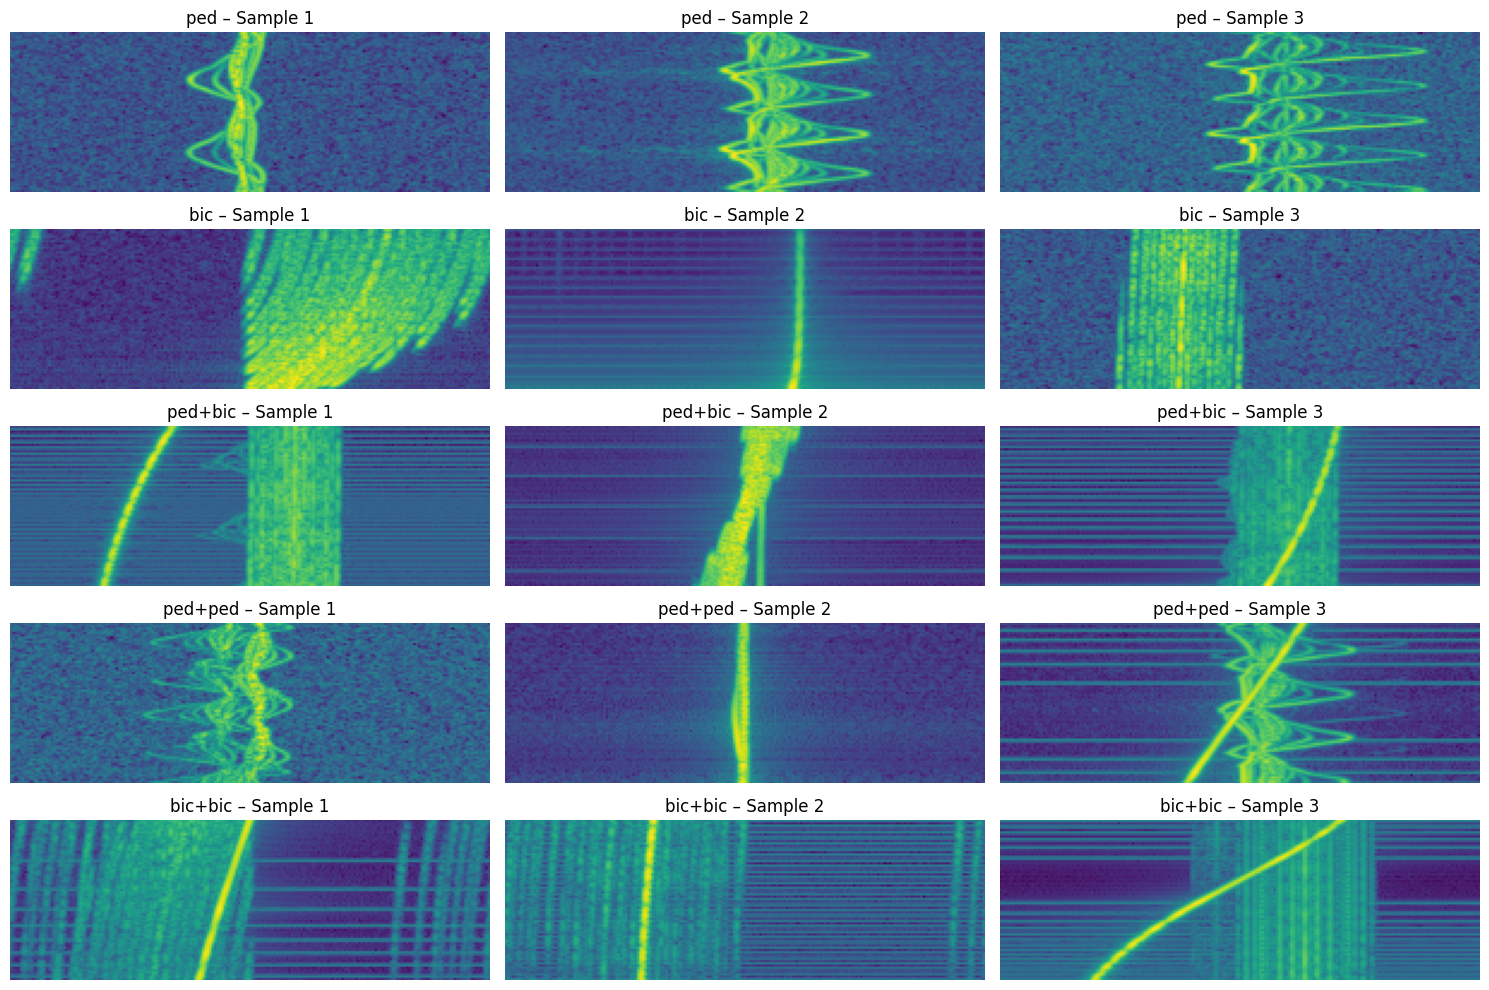

In [ ]:
num_samples_per_class = 3

unique_classes = np.unique(y)

fig, axes = plt.subplots(len(unique_classes), num_samples_per_class, figsize=(15, 10))


for i, cls in enumerate(unique_classes):
    indices = np.where(y == cls)[0][:num_samples_per_class]
    for j, idx in enumerate(indices):
        ax = axes[i, j] if len(unique_classes) > 1 else axes[j]
        ax.imshow(X[idx], aspect='auto', cmap='viridis')
        ax.set_title(f"{label_names[cls - 1]} – Sample {j+1}")
        ax.axis('off')

plt.tight_layout()
plt.show()

As stated above, the X-axis represents the time while the Y-axis the Doppler frequency, how and how fast the object moves to and from the sensor.

The intensity of the colour describes the magnitude of the signal, i.e. we expect two pedestrians (ped+ped) to show a brighter yellow than only one (ped).

Below, the bar plot shows the distribution of the observations among the five classes, which is balanced with 4000 observation per class.


<a name='descriptive-statistics'></a>
## Descriptive statistics

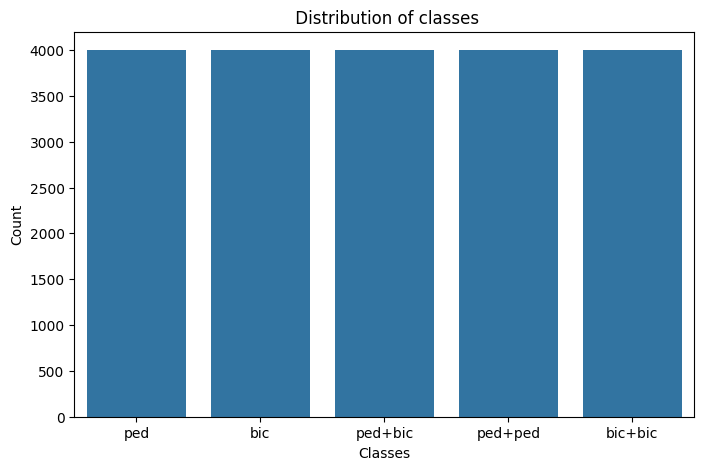

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title(" Distribution of classes")
plt.xticks(ticks=range(len(label_names)), labels=label_names)
plt.show()


We computed mean and standard deviation for each class. In our case, the mean is the average pixel intesity across all spectograms of a given class.




In [ ]:
print("Labels statistics:\n")
print(f"{'Label':<12} {'Mean':<12} {'Std Dev':<12}")
print("-" * 50)

for class_idx in range(len(label_names)):

    class_mask = np.argmax(y_cat, axis=1) == class_idx
    class_data = X[class_mask]

    if len(class_data) > 0:
        mean_val = np.mean(class_data)
        std_val = np.std(class_data)

        print(f"{label_names[class_idx]:<12} {mean_val:<12.4f} {std_val:<12.4f}")
    else:
        print(f"{label_names[class_idx]:<12} {'N/A':<12} {'N/A':<12} {'0':<12}")


Labels statistics:

Label        Mean         Std Dev     
--------------------------------------------------
ped          0.4786       0.1156      
bic          0.4964       0.1486      
ped+bic      0.4987       0.1513      
ped+ped      0.4726       0.1231      
bic+bic      0.5205       0.1619      


The statistics' results between the classes are very similar. Bic+Bic has the highest mean (0.5205) and the highest standard deviation (0.1619).

Ped and Ped+Ped show  low means and as noticeable in the spectrograms, the two patterns are similar. We expect models to struggle to differentiate them.




<a name="data-preprocessing"></a>
# Data Preprocessing

<a name="split-data-in-train-and-validation"></a>
## Split Data in Train and Validation

We split the train dataset into train (80% of train data) and validation (20% of train data).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print(f"Training set: {X_train.shape[0]} rows")
print(f"Validation set: {X_val.shape[0]} rows")
print(f"Training memory: ~{X_train.nbytes / 1024**2:.1f} MB")

del X, y, y_cat

Training set: 16000 rows
Validation set: 4000 rows
Training memory: ~878.9 MB


<a name="defining-preprocessing-function"></a>
## Defining Preprocessing Function

We convert the numpy arrays into a dataset readable by Tensorflow.
Since the micro-doppler signals are already normalized, the only preprocessing step was to add a channel dimension to match CNN requirement.

Lastly, we grouped the data in batches of 64, while mixing the data to avoid training patterns.

In [ ]:
def preprocess(x, y):
    x = tf.expand_dims(x, -1)
    x = tf.cast(x, tf.float32)
    return x, y

batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)


<a name="model-definition-and-training"></a>
# Model Definition and Training

<a name="3-cnn2d"></a>
## Model 1: 3 CNN2d

We start with a model made of three 2-dimensional Conv layers where the number of filters doubles at each layer (16,32,64). Each layer has a 3x3 kernel, uses 'relu' activation function and is followed by 2-Dimensional MaxPooling.

Lastly, we add a GlobalAveragePooling2D layer, followed by a Dense layer and a Dropout layer (0.3) to avoid possible overfitting. In each training epoch, it shuts off 30% percent of the neurons.

The GlobalAveragePooling2D layer transforms a multidimensional tensor in a 1 dimensional tensor, by computing the average of each feature map, which is needed as input for dense layers. Alternatives are averageMaxPooling2D or globalMaxPooling2D. We will use Adam optimizer and categorical cross-entropy, a loss function used in multi-classes classification tasks.

As callback, we set earlystopping with patience 3. It is a regularization technique to prevent overfitting that cease the model when, in our case, the validation loss stops improving.




### Architecture

In [ ]:
def build_model_cnn():
    input_shape = (72, 200, 1)
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(5, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


MOD1 = build_model_cnn()
MOD1.summary()

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 72, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 200, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 100, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 18, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 25, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,261 (126.02 KB)

 Trainable params: 32,261 (126.02 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
history = MOD1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2108 - loss: 1.6011 - val_accuracy: 0.3635 - val_loss: 1.4114
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3578 - loss: 1.4026 - val_accuracy: 0.3280 - val_loss: 1.4073
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3814 - loss: 1.3118 - val_accuracy: 0.4175 - val_loss: 1.2166
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4108 - loss: 1.2326 - val_accuracy: 0.4317 - val_loss: 1.1777
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4396 - loss: 1.1723 - val_accuracy: 0.4680 - val_loss: 1.1151
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4454 - loss: 1.1460 - val_accuracy: 0.4868 - val_loss: 1.0726
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4865 - loss: 1.0798 - val_accuracy: 0.3945 - val_loss: 1.2588
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4929 - loss: 1.0657 - val_acc

In [ ]:
MOD1.save("/content/drive/My Drive/MOD1.keras")

### Results

VALUTAZIONE FINALE
Training Accuracy: 0.6479 (64.79%)
Validation Accuracy: 0.6455 (64.55%)
Training Loss: 0.7904
Validation Loss: 0.8002


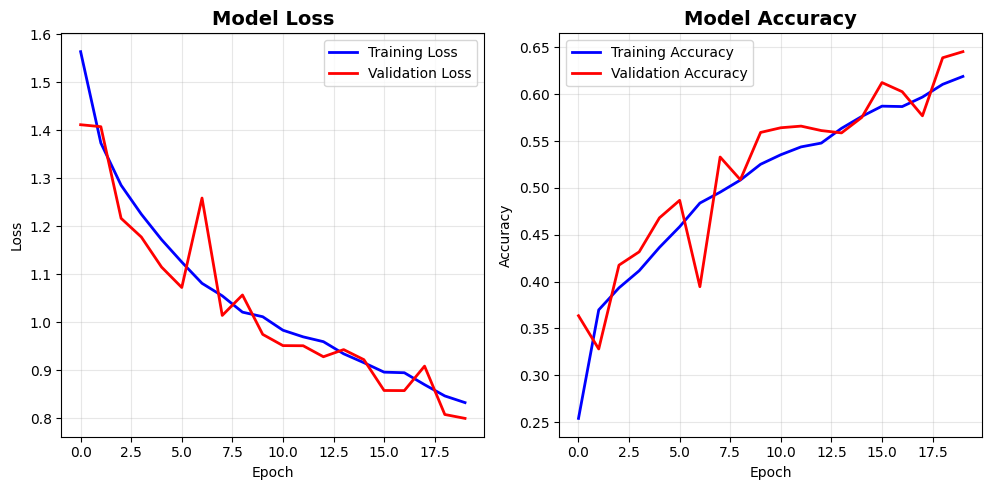

In [ ]:
if 'history' in locals():

    print("VALUTAZIONE FINALE")
    print("=" * 40)

    train_loss, train_acc = MOD1.evaluate(train_ds, verbose=0)
    val_loss, val_acc = MOD1.evaluate(val_ds, verbose=0)

    print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



The model is not performing well, it almost reaches 0.65 of accuracy. The model is probably not complex enough to fit the data. Training and validation are close to each others, meaning the model is generalizing well.

### Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


<Figure size 600x600 with 0 Axes>

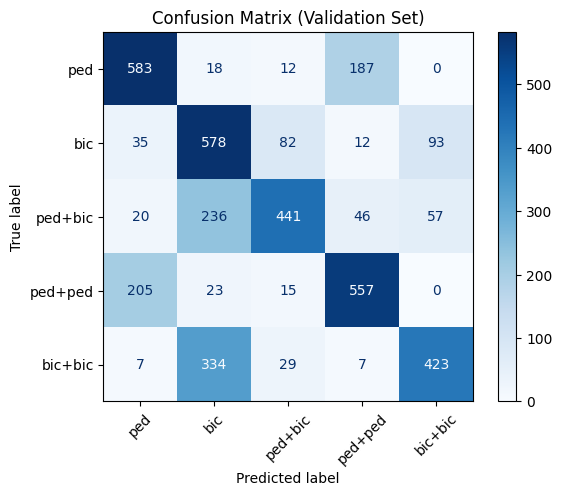

In [ ]:
y_pred_prob = MOD1.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)


y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.show()


We observe that the model struggles to recognize ped+ped and bic+bic, classifying them as a single object. We will focus on dealing with them.



### Model Structure


Generazione della visualizzazione del modello...


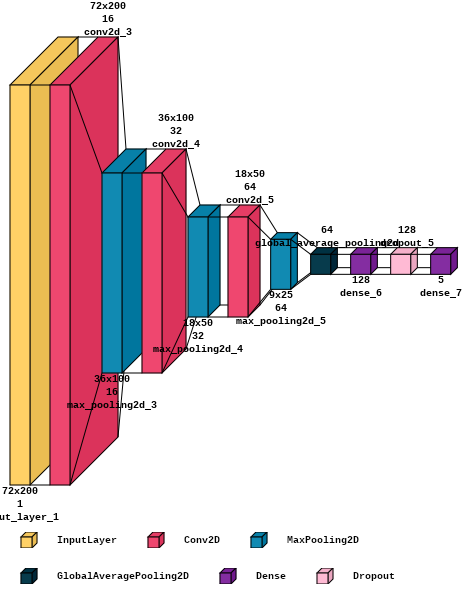

In [ ]:
try:
    font = ImageFont.truetype("LiberationMono-Bold.ttf", 10)
except OSError:
    print("Font 'LiberationMono-Bold.ttf' non trovato. Verrà usato il font di default.")
    font = None


def robust_text_callable(layer_index, layer):
    above = bool(layer_index % 2)


    shape = layer.output.shape
    if isinstance(shape, list):
        shape = shape[0]

    output_shape = [dim for dim in shape if dim is not None]

    output_shape_txt = ""
    for i, dim in enumerate(output_shape):
        output_shape_txt += str(dim)
        if i < len(output_shape) - 2:
            output_shape_txt += "x"
        elif i == len(output_shape) - 2:
            output_shape_txt += "\n"

    output_shape_txt += f"\n{layer.name}"

    return output_shape_txt, above

print("\nGenerazione della visualizzazione del modello...")
viz = visualkeras.layered_view(
    MOD1,
    legend=True,
    font=font,
    spacing=20,
    draw_volume=True,
    scale_xy=2,
    scale_z=0.1,
    text_callable=robust_text_callable
)

viz

<a name="4-cnn2d"></a>
## Model 2: 4 CNN2d

We try to increase the complexity of the model by adding a conv2d layer to see if it catches the differences between two elements/ one element.

### Architecture

In [ ]:
def build_model_cnn():
    input_shape = (72, 200, 1)
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)


    x = layers.MaxPooling2D((2, 2))(x)


    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(5, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


MOD2 = build_model_cnn()
MOD2.summary()


early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 72, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 200, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 36, 100, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 18, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 9, 25, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 12, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,917 (1.74 MB)

 Trainable params: 454,917 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
history = MOD2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.2050 - loss: 1.6095 - val_accuracy: 0.2202 - val_loss: 1.6095
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.2530 - loss: 1.5631 - val_accuracy: 0.3587 - val_loss: 1.3603
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3941 - loss: 1.3101 - val_accuracy: 0.4445 - val_loss: 1.1803
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4499 - loss: 1.1518 - val_accuracy: 0.5138 - val_loss: 1.0530
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5179 - loss: 1.0387 - val_accuracy: 0.5677 - val_loss: 0.9377
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5696 - loss: 0.9448 - val_accuracy: 0.5875 - val_loss: 0.8765
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.5982 - loss: 0.8889 - val_accuracy: 0.6310 - val_loss: 0.8127
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6184 - loss: 0.8431 - val_ac

In [ ]:
MOD2.save("/content/drive/My Drive/MOD2.keras")

### Results

VALUTAZIONE FINALE
Training Accuracy: 0.7706 (77.06%)
Validation Accuracy: 0.7505 (75.05%)
Training Loss: 0.5414
Validation Loss: 0.5712


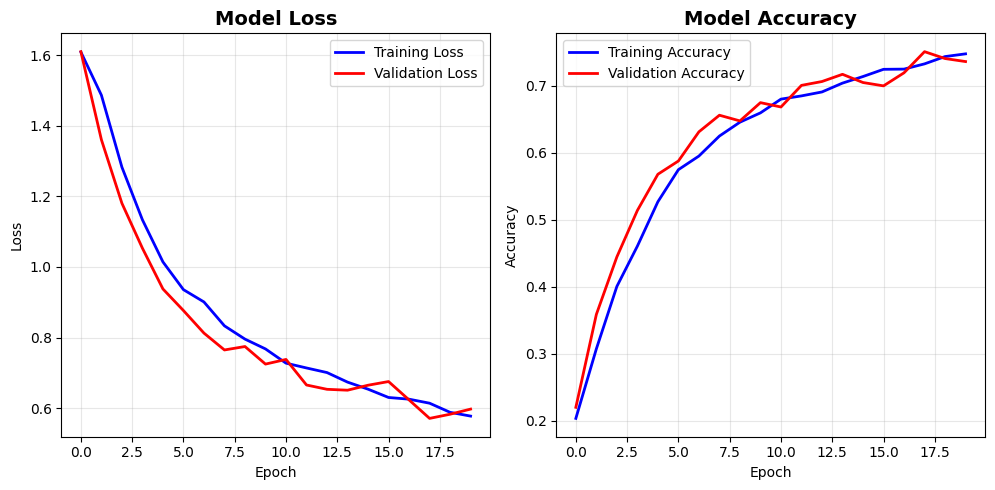

In [ ]:
if 'history' in locals():

    print("VALUTAZIONE FINALE")
    print("=" * 40)

    train_loss, train_acc = MOD2.evaluate(train_ds, verbose=0)
    val_loss, val_acc = MOD2.evaluate(val_ds, verbose=0)

    print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")


    plt.figure(figsize=(15, 5))


    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)



    plt.tight_layout()
    plt.show()

The performance of the model increases significantly, accuracy improves of about 10%.


### Confusion matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


<Figure size 600x600 with 0 Axes>

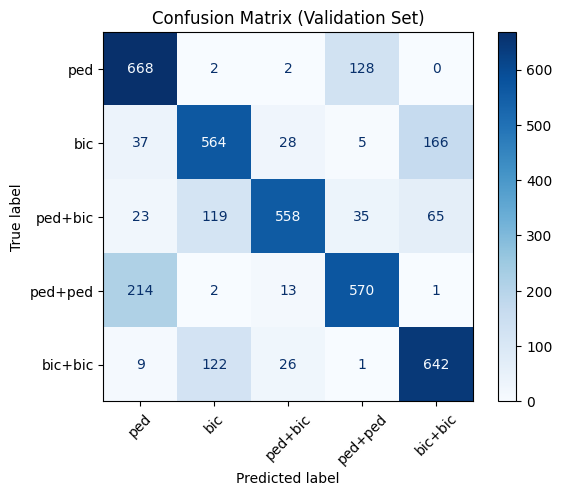

In [ ]:
y_pred_prob = MOD2.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.show()


The model is missclassifiyng the same classes as the previous one but improving. It is still classifying many bic as bic+bic and many ped as ped+ped, and viceversa. The improvements are not significant so we'll try layers specialized in temporal dependencies.

### Model Structure


Generazione della visualizzazione del modello...


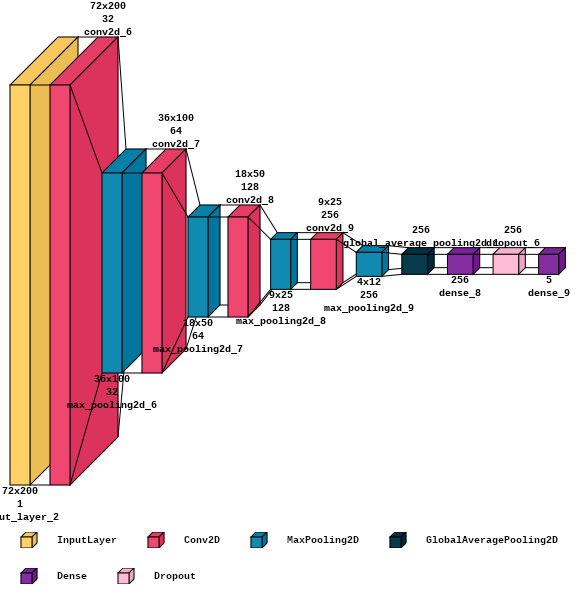

In [ ]:

try:
    font = ImageFont.truetype("LiberationMono-Bold.ttf", 10)
except OSError:
    print("Font 'LiberationMono-Bold.ttf' non trovato. Verrà usato il font di default.")
    font = None

def robust_text_callable(layer_index, layer):
    above = bool(layer_index % 2)

    shape = layer.output.shape
    if isinstance(shape, list):
        shape = shape[0]

    output_shape = [dim for dim in shape if dim is not None]

    output_shape_txt = ""
    for i, dim in enumerate(output_shape):
        output_shape_txt += str(dim)
        if i < len(output_shape) - 2:
            output_shape_txt += "x"
        elif i == len(output_shape) - 2:
            output_shape_txt += "\n"

    output_shape_txt += f"\n{layer.name}"

    return output_shape_txt, above

print("\nGenerazione della visualizzazione del modello...")
viz = visualkeras.layered_view(
    MOD2,
    legend=True,
    font=font,
    spacing=20,
    draw_volume=True,
    scale_xy=2,
    scale_z=0.1,
    text_callable=robust_text_callable
)

viz

<a name="3-cnn2d--lstm"></a>
## Model 3:  3 CNN2d + LSTM

For the next model, we start with three conv2d layers, followed by batch normalization and maxpooling2D. The filter size starts from 32 and doubles each layer.
In the spectograms, we observed that bicyles have a straighter vertical pattern while pedestrians have some sort of loops and more wider amplitude. We tried to capture this differences.

Specifically, the first layer has a filter dimension of 1x25, to catch patterns over time (over x axis), for example the ciclycle movements of pedestrians.

The second layer has dimension 3x15 to focus on frequencies on small temporal windows. Here the maxpooling is 2x2 to reduce symmetrically frequency and time.

The third layer has a smaller filter dimension (3x7). It detects smaller details.

Now, we decide to add a LSTM layer. To do so, we need to reshape the input in 18 time steps for 3200 features. The LSTM is able to detect temporal dependencies, motions and sequency dynamics over frames.

Lastly, a dense layer with batch normalization and dropout.


### Architecture

In [ ]:

def build_model_cnn_lstm_temporal_focus():
    input_shape = (72, 200, 1)
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (1, 25), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((1, 2))(x)

    x = layers.Conv2D(64, (3, 15), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 7), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Reshape((18, 25 * 128))(x)

    x = layers.LSTM(64)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(5, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

MOD3 = build_model_cnn_lstm_temporal_focus()
MOD3.summary()

callbacks = [
    EarlyStopping( monitor='val_loss',patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
]



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 72, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 200, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 72, 200, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 72, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 72, 100, 64)    │        92,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 72, 100, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 36, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 36, 50, 128)    │       172,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 36, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 18, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 18, 3200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       835,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,111,429 (4.24 MB)

 Trainable params: 1,110,725 (4.24 MB)

 Non-trainable params: 704 (2.75 KB)

### Training

In [ ]:
history = MOD3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 178ms/step - accuracy: 0.3007 - loss: 1.9144 - val_accuracy: 0.2400 - val_loss: 1.6591 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 177ms/step - accuracy: 0.4381 - loss: 1.2696 - val_accuracy: 0.2243 - val_loss: 2.5471 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5458 - loss: 1.0268
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 175ms/step - accuracy: 0.5459 - loss: 1.0267 - val_accuracy: 0.3400 - val_loss: 1.6986 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - accuracy: 0.6382 - loss: 0.8520 - val_accuracy: 0.6047 - val_loss: 0.8727 - learning_rate: 5.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.6889 - loss: 0.7570 - val_accuracy: 0.6475 - val_loss: 0.7919 - learning_rate: 5.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 172ms/step - accurac

In [ ]:
MOD3.save("/content/drive/My Drive/MOD3.keras")

### Results

VALUTAZIONE FINALE
Training Accuracy: 0.9238 (92.38%)
Validation Accuracy: 0.8095 (80.95%)
Training Loss: 0.2138
Validation Loss: 0.4895


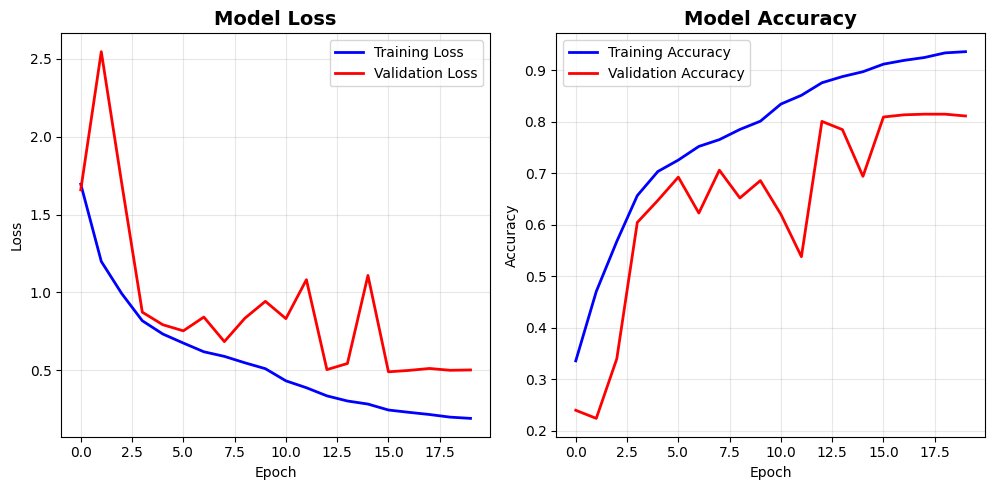

In [ ]:
if 'history' in locals():

    print("VALUTAZIONE FINALE")
    print("=" * 40)

    train_loss, train_acc = MOD3.evaluate(train_ds, verbose=0)
    val_loss, val_acc = MOD3.evaluate(val_ds, verbose=0)

    print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")


    plt.figure(figsize=(15, 5))


    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)


    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

The model reached a good level of accuracy but it is starting to overfit. The plot shows its instability.

### Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


<Figure size 600x600 with 0 Axes>

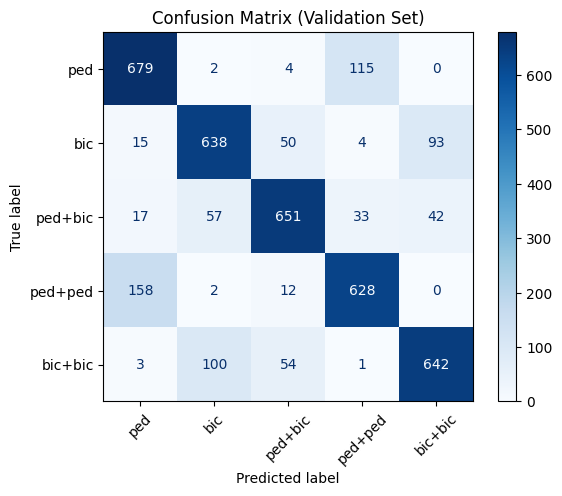

In [ ]:
y_pred_prob = MOD3.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.show()


While the previous model was better at some classes rather than others, this model performs across all classes.
It is still stuggling with two-elements classes, especially with ped+ped.

### Model Structure


Generazione della visualizzazione del modello...


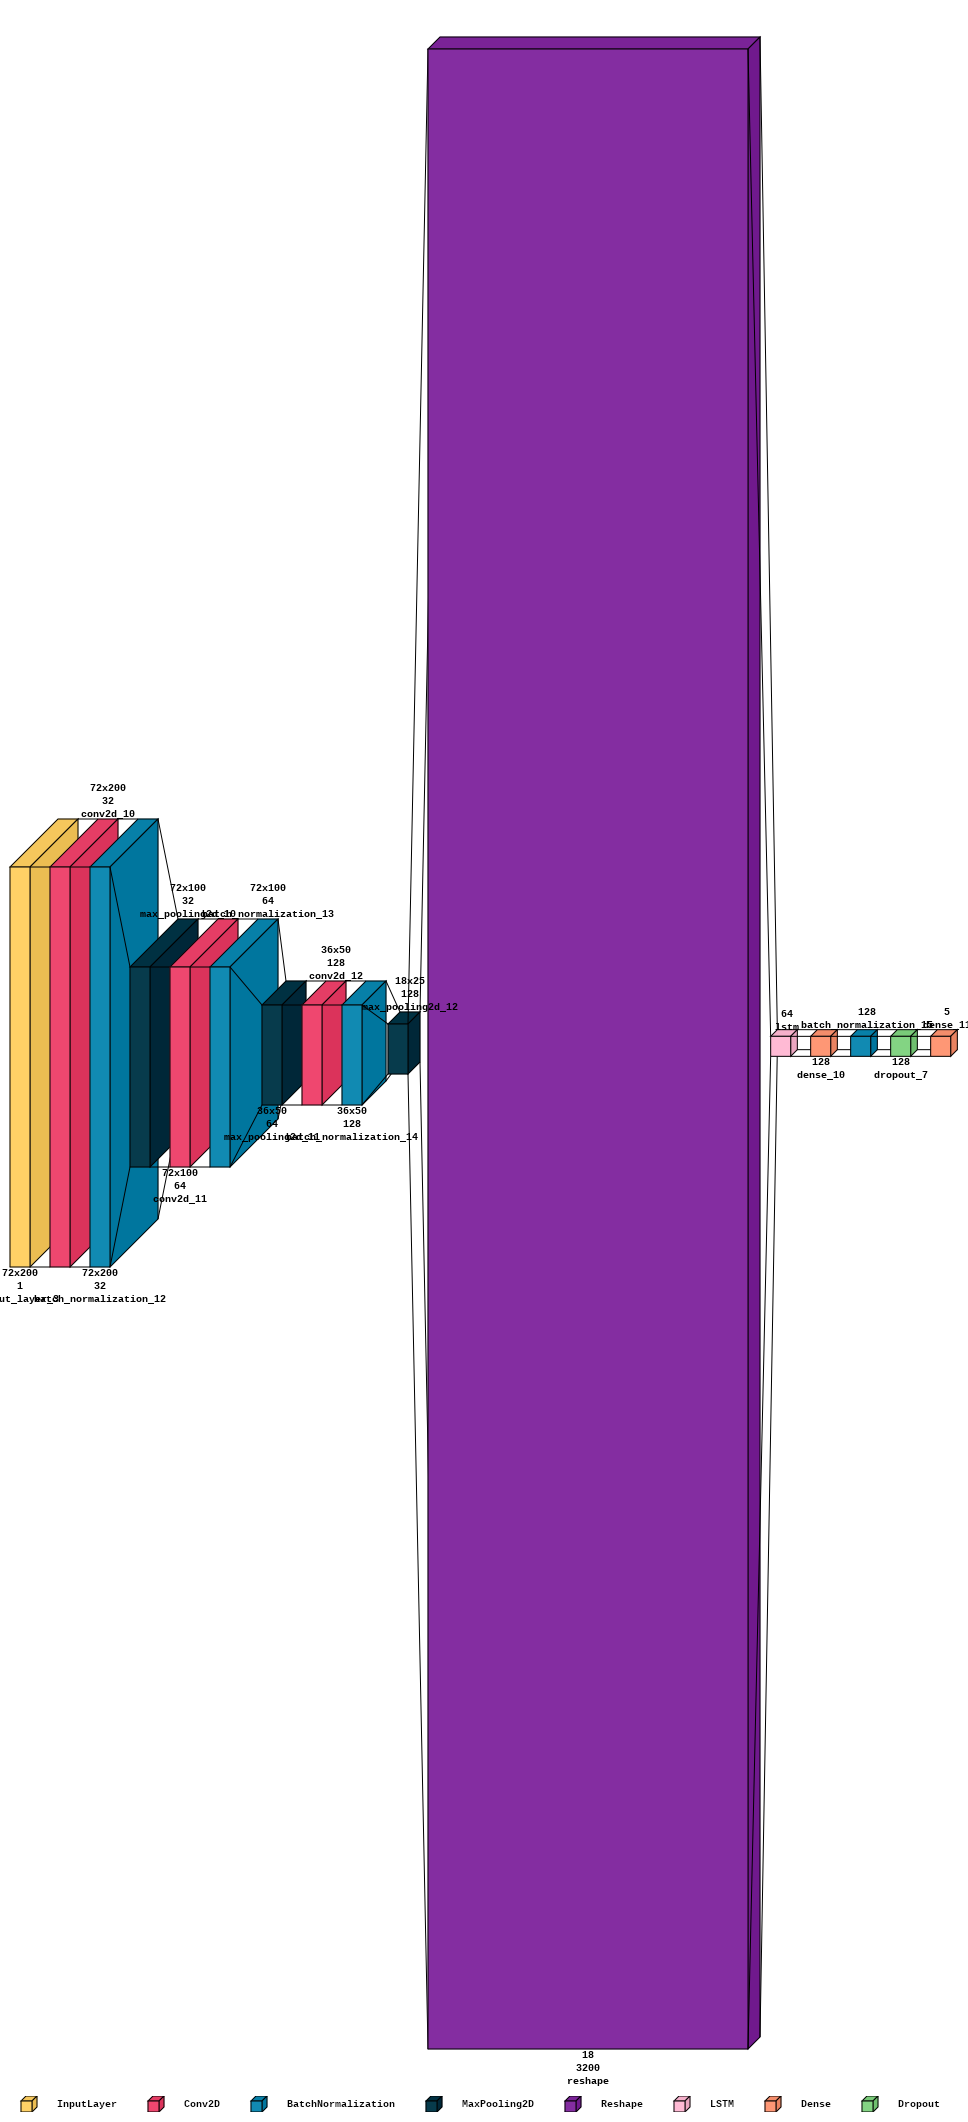

In [ ]:

try:
    font = ImageFont.truetype("LiberationMono-Bold.ttf", 10)
except OSError:
    print("Font 'LiberationMono-Bold.ttf' non trovato. Verrà usato il font di default.")
    font = None


def robust_text_callable(layer_index, layer):
    above = bool(layer_index % 2)


    shape = layer.output.shape
    if isinstance(shape, list):
        shape = shape[0]

    output_shape = [dim for dim in shape if dim is not None]
    output_shape_txt = ""
    for i, dim in enumerate(output_shape):
        output_shape_txt += str(dim)
        if i < len(output_shape) - 2:
            output_shape_txt += "x"
        elif i == len(output_shape) - 2:
            output_shape_txt += "\n"

    output_shape_txt += f"\n{layer.name}"

    return output_shape_txt, above


print("\nGenerazione della visualizzazione del modello...")
viz = visualkeras.layered_view(
    MOD3,
    legend=True,
    font=font,
    spacing=20,
    draw_volume=True,
    scale_xy=2,
    scale_z=0.1,
    text_callable=robust_text_callable
)

viz

<a name="3-cnn2d--bilstm"></a>
## Model 4: 3 CNN2d + BiLSTM

 Following the structure of the previous model, we modify the dimension of the filters, increasing also the maxpooling2D kernel size. Larger filters should capture wide patterns recognizing the shapes of the signals. We substitute LSTM with bi-directional LSTM to catch overlapping features as it analyses movements in both directions. This should help with the classes with two elements.

### Architecture

In [ ]:
def cnn_bilstm_model():
    input_shape = (72, 200, 1)
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(16, kernel_size=(10, 10), activation='relu', padding='same', name='conv1')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(4, 8), strides=2, name='maxpool1')(x)

    x = layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', name='conv2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 5), strides=2, name='maxpool2')(x)

    x = layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', name='conv3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, name='maxpool3')(x)

    x = layers.Reshape((8, 23 * 32), name='reshape_for_lstm')(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False), name='bi_lstm1')(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(5, activation='softmax', name='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

MOD4 = cnn_bilstm_model()

MOD4.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
]

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 72, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 72, 200, 16)    │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 72, 200, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 35, 97, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 35, 97, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 35, 97, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 17, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 17, 47, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 17, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3 (MaxPooling2D)         │ (None, 8, 23, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_lstm (Reshape)      │ (None, 8, 736)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm1 (Bidirectional)        │ (None, 128)            │       410,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,373 (1.82 MB)

 Trainable params: 475,829 (1.82 MB)

 Non-trainable params: 544 (2.12 KB)

### Training

In [ ]:
history = MOD4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.3567 - loss: 1.6011 - val_accuracy: 0.2495 - val_loss: 1.6491 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.5453 - loss: 1.0132 - val_accuracy: 0.2878 - val_loss: 2.5354 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6585 - loss: 0.7971
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6585 - loss: 0.7971 - val_accuracy: 0.3080 - val_loss: 2.3111 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.7105 - loss: 0.6812 - val_accuracy: 0.6687 - val_loss: 0.7520 - learning_rate: 5.0000e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7633 - loss: 0.5877 - val_accuracy: 0.7415 - val_loss: 0.6136 - learning_rate: 5.0000e-04
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.77

In [ ]:
MOD4.save("/content/drive/My Drive/MOD4.keras")

### Results

VALUTAZIONE FINALE
Training Accuracy: 0.8322 (83.22%)
Validation Accuracy: 0.7995 (79.95%)
Training Loss: 0.4088
Validation Loss: 0.4968


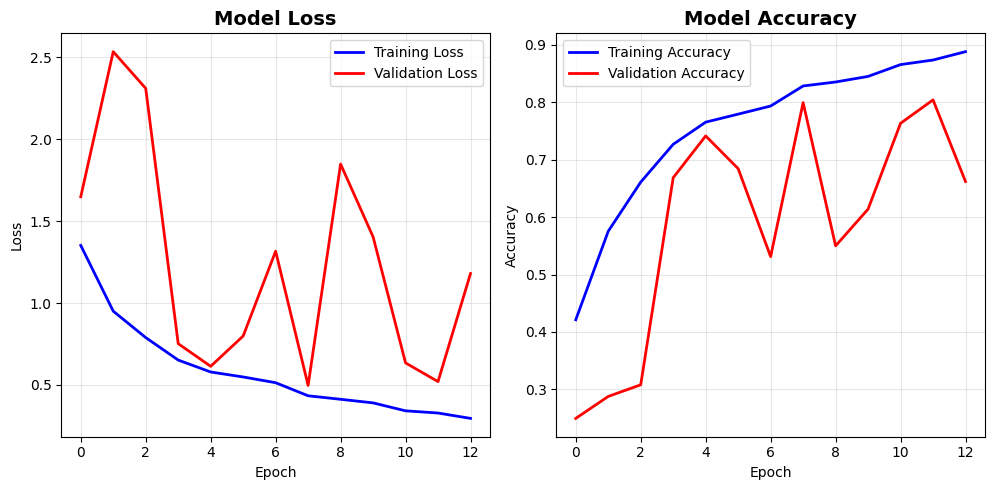

In [ ]:
if 'history' in locals():

    print("VALUTAZIONE FINALE")
    print("=" * 40)

    train_loss, train_acc = MOD4.evaluate(train_ds, verbose=0)
    val_loss, val_acc = MOD4.evaluate(val_ds, verbose=0)

    print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

The model's accuracy has slighlty decreased.

### Confusion matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


<Figure size 600x600 with 0 Axes>

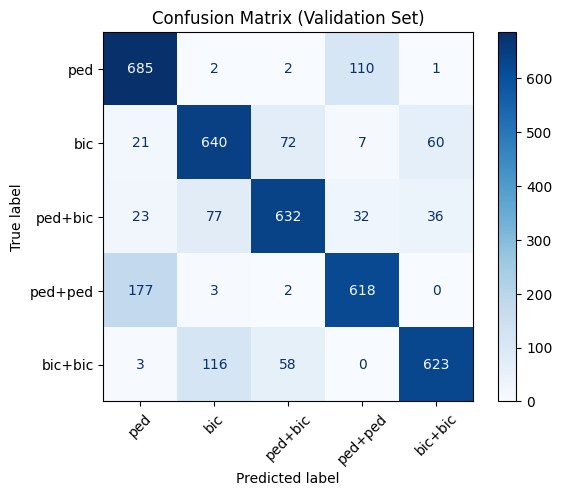

In [ ]:
y_pred_prob = MOD4.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

The model better recognizes ped+bic but it is slightly worse in the other two-element classes.

### Model Structure


Generazione della visualizzazione del modello...


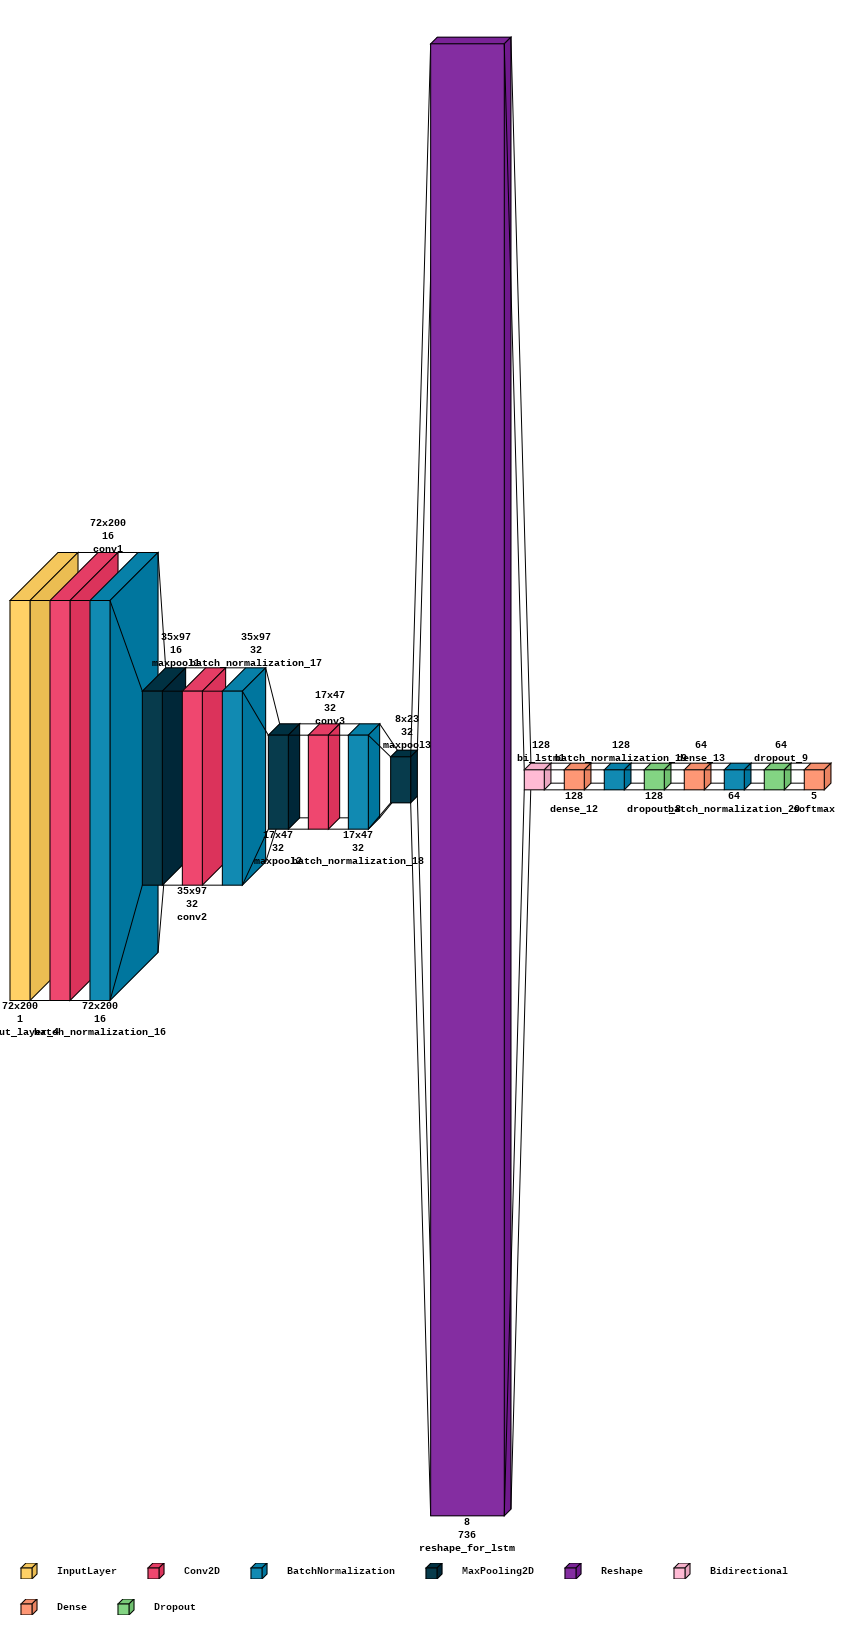

In [ ]:

try:
    font = ImageFont.truetype("LiberationMono-Bold.ttf", 10)
except OSError:
    print("Font 'LiberationMono-Bold.ttf' non trovato. Verrà usato il font di default.")
    font = None


def robust_text_callable(layer_index, layer):
    above = bool(layer_index % 2)

    shape = layer.output.shape
    if isinstance(shape, list):
        shape = shape[0]

    output_shape = [dim for dim in shape if dim is not None]
    output_shape_txt = ""
    for i, dim in enumerate(output_shape):
        output_shape_txt += str(dim)
        if i < len(output_shape) - 2:
            output_shape_txt += "x"
        elif i == len(output_shape) - 2:
            output_shape_txt += "\n"

    output_shape_txt += f"\n{layer.name}"

    return output_shape_txt, above

print("\nGenerazione della visualizzazione del modello...")
viz = visualkeras.layered_view(
    MOD4,
    legend=True,
    font=font,
    spacing=20,
    draw_volume=True,
    scale_xy=2,
    scale_z=0.1,
    text_callable=robust_text_callable
)

viz

<a name="3-cnn2d--cnn1d--lstm"></a>
## Model 5: 3 CNN2d + CNN1d + LSTM

The two-dimensions convolutional layers are treating the spectrograms as an image, an isolated frame, to recognize patterns. Since a spectograms represent temporal sequences, we add a 1 dimension convolutional layer, which works along the time axis,  to analyze how patterns dynamically evolve . Additionally, it filters signals reducing LSTM's workload.


### Architecture

In [ ]:
def Mod_5():

    input_shape = (72, 200, 1)
    inputs = keras.Input(shape=input_shape, name='input')


    x = layers.Conv2D(32, (7, 7), padding='same', name='conv2d_1')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name='relu2d_1')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, name='maxpool2d_1')(x)

    x = layers.Conv2D(64, (5, 5), padding='same', name='conv2d_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name='relu2d_2')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, name='maxpool2d_2')(x)

    x = layers.Conv2D(128, (3, 3), padding='same', name='conv2d_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name='relu2d_3')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, name='maxpool2d_3')(x)

    x = layers.Reshape((9, 25 * 128), name='reshape_for_cnn1d')(x)

    x = layers.Conv1D(128, kernel_size=3, padding='same', name='conv1d_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name='relu1d_1')(x)
    x = layers.MaxPooling1D(pool_size=2, strides=2, name='maxpool1d_1')(x)

    x = layers.LSTM(256, return_sequences=False, name='lstm_1')(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(5, activation='softmax', name='output')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

MOD5 = Mod_5()

MOD5.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
]


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 72, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 200, 32)    │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 72, 200, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2d_1 (ReLU)                 │ (None, 72, 200, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 36, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 100, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 36, 100, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2d_2 (ReLU)                 │ (None, 36, 100, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 18, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 18, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2d_3 (ReLU)                 │ (None, 18, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 9, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_cnn1d (Reshape)     │ (None, 9, 3200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 9, 128)         │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1d_1 (ReLU)                 │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_1 (MaxPooling1D)      │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,793,541 (6.84 MB)

 Trainable params: 1,792,453 (6.84 MB)

 Non-trainable params: 1,088 (4.25 KB)

### Training

In [ ]:
history = MOD5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.4394 - loss: 1.3819 - val_accuracy: 0.2618 - val_loss: 2.2863 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6889 - loss: 0.7520 - val_accuracy: 0.4295 - val_loss: 1.4313 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.7472 - loss: 0.6205 - val_accuracy: 0.7525 - val_loss: 0.6188 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.7761 - loss: 0.5534 - val_accuracy: 0.4605 - val_loss: 1.6617 - learning_rate: 0.0010
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8088 - loss: 0.4746
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.8088 - loss: 0.4746 - val_accuracy: 0.6817 - val_loss: 0.8157 - learning_rate: 0.0010
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.8424 - los

In [ ]:
MOD5.save("/content/drive/My Drive/MOD5.keras")

### Results

VALUTAZIONE FINALE
Training Accuracy: 0.9399 (93.99%)
Validation Accuracy: 0.8587 (85.87%)
Training Loss: 0.1534
Validation Loss: 0.4009


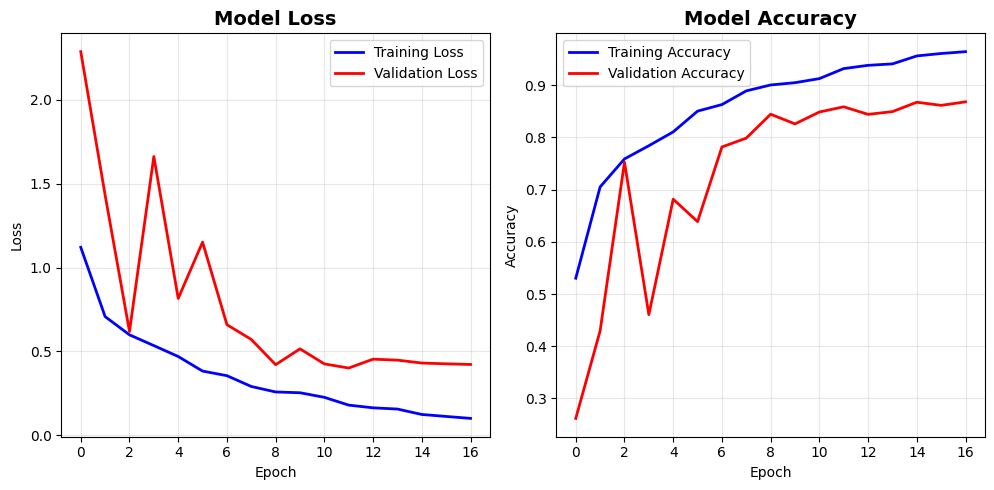

In [ ]:
if 'history' in locals():
    print("VALUTAZIONE FINALE")
    print("=" * 40)

    train_loss, train_acc = MOD5.evaluate(train_ds, verbose=0)
    val_loss, val_acc = MOD5.evaluate(val_ds, verbose=0)

    print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

This model has reached the best performance so far and the accuracy has stabilized. However, the model has a higher number of parameters compared to the previous one.

### Confusion matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


<Figure size 600x600 with 0 Axes>

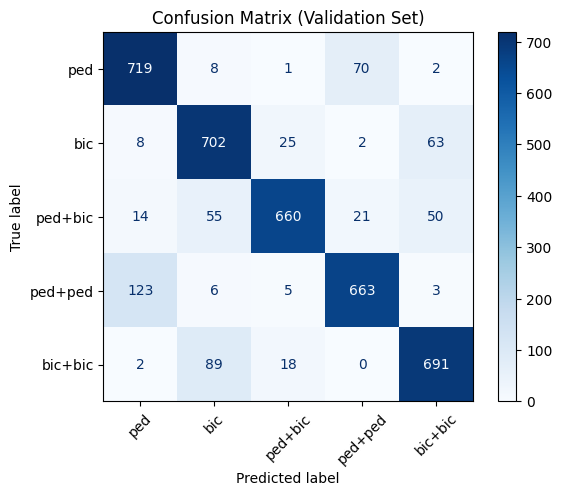

In [ ]:
y_pred_prob = MOD5.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

The model has improved in recognizing ped+ped versus ped, and bic+bic versus bic, and viceversa. Overall, we observe improvements across all classes.

### Model Structure


Generazione della visualizzazione del modello...


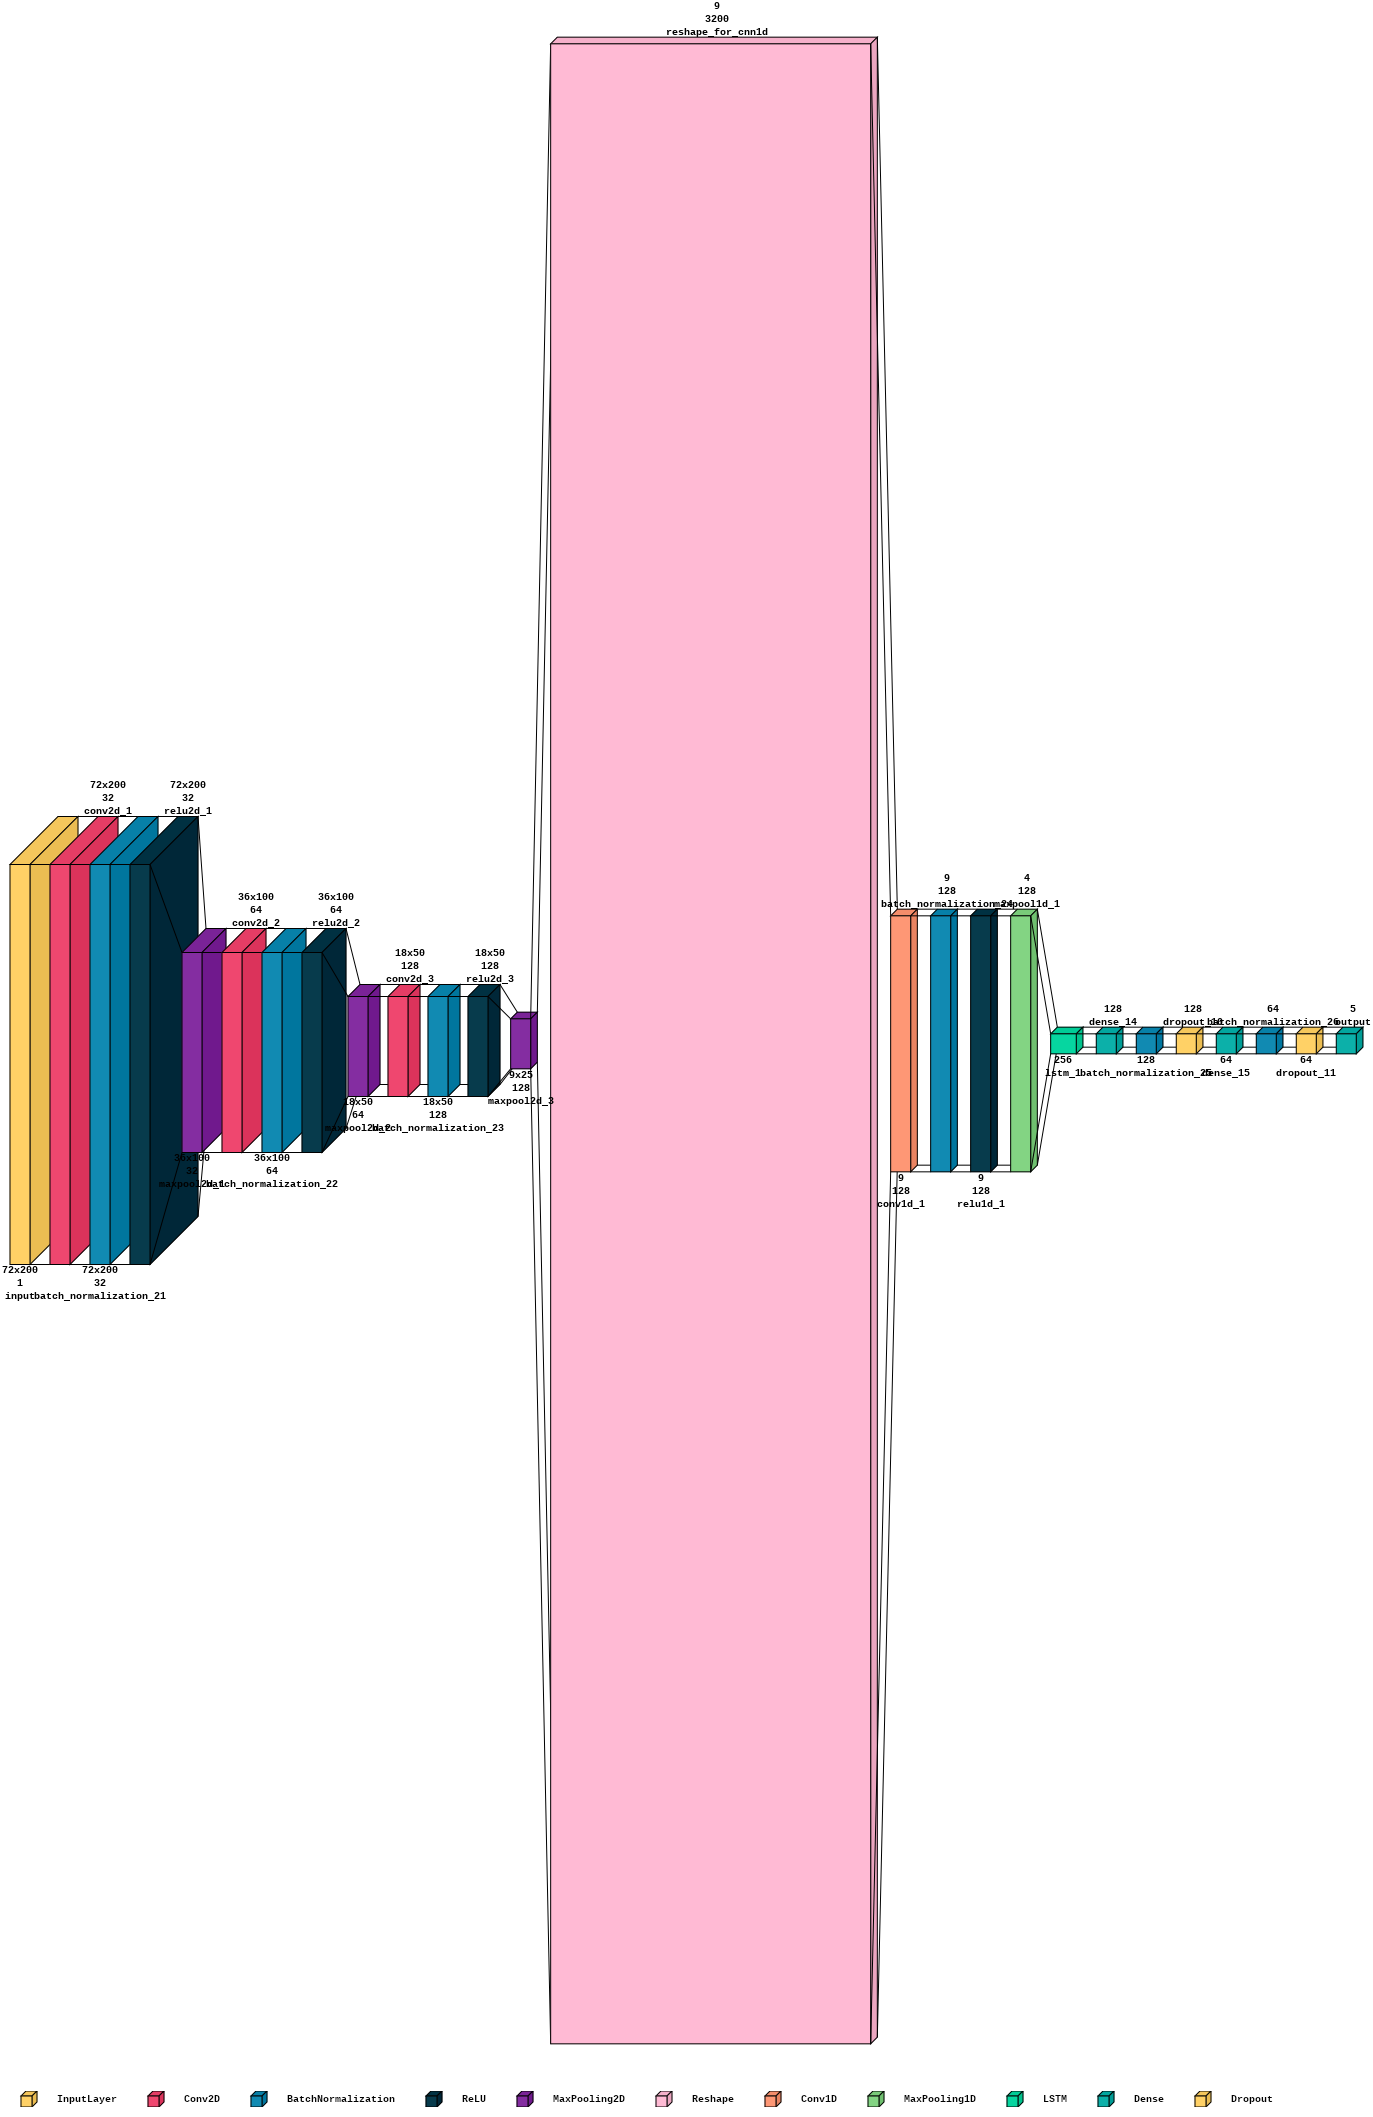

In [ ]:
try:
    font = ImageFont.truetype("LiberationMono-Bold.ttf", 10)
except OSError:
    print("Font 'LiberationMono-Bold.ttf' non trovato. Verrà usato il font di default.")
    font = None

def robust_text_callable(layer_index, layer):
    above = bool(layer_index % 2)

    shape = layer.output.shape
    if isinstance(shape, list):
        shape = shape[0]

    output_shape = [dim for dim in shape if dim is not None]
    output_shape_txt = ""
    for i, dim in enumerate(output_shape):
        output_shape_txt += str(dim)
        if i < len(output_shape) - 2:
            output_shape_txt += "x"
        elif i == len(output_shape) - 2:
            output_shape_txt += "\n"

    output_shape_txt += f"\n{layer.name}"

    return output_shape_txt, above

print("\nGenerazione della visualizzazione del modello...")
viz = visualkeras.layered_view(
    MOD5,
    legend=True,
    font=font,
    spacing=20,
    draw_volume=True,
    scale_xy=2,
    scale_z=0.1,
    text_callable=robust_text_callable
)

viz

<a name="data-augmentation"></a>
# Data Augmentation

Models' performance has increased throughout the work. However, we still want to decrease the missclassified in ped+ped and bic+bic. We try to syntetically increase the number of spectograms for this two classes. We feed the augmented dataset to model 5 as it is the best one so far.

In [ ]:



n_synt = 500


y_labels = np.argmax(y_train, axis=1)
idx_class3 = np.where(y_labels == 3)[0]
idx_class4 = np.where(y_labels == 4)[0]


def time_warp(image, factor_range=(0.9, 1.1)):

    factor = np.random.uniform(*factor_range)
    warped = zoom(image, (1, factor), order=1)

    original_width = image.shape[1]
    if warped.shape[1] > original_width:
        warped = warped[:, :original_width]
    else:
        pad_w = original_width - warped.shape[1]
        warped = np.pad(warped, ((0, 0), (0, pad_w)), mode='constant')
    return warped

def augment_timewarp(X_data, indices, label_index, n_augmented):
    augmented = []
    for _ in range(n_augmented):
        i = np.random.choice(indices)
        img = X_data[i].squeeze()
        img_aug = time_warp(img)


        augmented.append(img_aug)
    labels = np.tile(np.eye(5)[label_index], (n_augmented, 1))
    return np.array(augmented), labels

X_aug_3, y_aug_3 = augment_timewarp(X_train, idx_class3, 3, n_synt)
X_aug_4, y_aug_4 = augment_timewarp(X_train, idx_class4, 4, n_synt)


X_train_augmented = np.concatenate([X_train, X_aug_3, X_aug_4], axis=0)
y_train_augmented = np.concatenate([y_train, y_aug_3, y_aug_4], axis=0)

print("Original X_train:", X_train.shape)
print("Augmented X_train:", X_train_augmented.shape)


Original X_train: (16000, 72, 200)
Augmented X_train: (17000, 72, 200)


In [ ]:
train_ds_augmented = tf.data.Dataset.from_tensor_slices((X_train_augmented, y_train_augmented)) \
    .map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds_augmented = train_ds_augmented.map(lambda x, y: (x, tf.cast(y, tf.float32)))



In [ ]:
def Mod_5A():

    input_shape = (72, 200, 1)
    inputs = keras.Input(shape=input_shape, name='input')

    x = layers.Conv2D(32, (7, 7), padding='same', name='conv2d_1')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name='relu2d_1')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, name='maxpool2d_1')(x)

    x = layers.Conv2D(64, (5, 5), padding='same', name='conv2d_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name='relu2d_2')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, name='maxpool2d_2')(x)

    x = layers.Conv2D(128, (3, 3), padding='same', name='conv2d_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name='relu2d_3')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, name='maxpool2d_3')(x)

    x = layers.Reshape((9, 25 * 128), name='reshape_for_cnn1d')(x)

    x = layers.Conv1D(128, kernel_size=3, padding='same', name='conv1d_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(name='relu1d_1')(x)
    x = layers.MaxPooling1D(pool_size=2, strides=2, name='maxpool1d_1')(x)

    x = layers.LSTM(256, return_sequences=False, name='lstm_1')(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(5, activation='softmax', name='output')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

MOD5A = Mod_5A()

MOD5A.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 72, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 200, 32)    │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 72, 200, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2d_1 (ReLU)                 │ (None, 72, 200, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 36, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 100, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 36, 100, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2d_2 (ReLU)                 │ (None, 36, 100, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 18, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 18, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2d_3 (ReLU)                 │ (None, 18, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 9, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_cnn1d (Reshape)     │ (None, 9, 3200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 9, 128)         │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1d_1 (ReLU)                 │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_1 (MaxPooling1D)      │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,793,541 (6.84 MB)

 Trainable params: 1,792,453 (6.84 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
history = MOD5A.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step - accuracy: 0.4238 - loss: 1.4258 - val_accuracy: 0.3007 - val_loss: 1.6554 - learning_rate: 0.0010
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.6257 - loss: 0.8924 - val_accuracy: 0.4090 - val_loss: 2.0456 - learning_rate: 0.0010
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7020 - loss: 0.7210
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
266/266 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.7021 - loss: 0.7207 - val_accuracy: 0.2517 - val_loss: 2.4263 - learning_rate: 0.0010
Epoch 4/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.7440 - loss: 0.6144 - val_accuracy: 0.4992 - val_loss: 1.4721 - learning_rate: 5.0000e-04
Epoch 5/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.7909 - loss: 0.5156 - val_accuracy: 0.6507 - val_loss: 0.9690 - learning_rate: 5.0000e-04
Epoch 6/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.80

In [ ]:
MOD5A.save("/content/drive/My Drive/MOD5A.keras")

VALUTAZIONE FINALE
Training Accuracy: 0.9774 (97.74%)
Validation Accuracy: 0.8683 (86.83%)
Training Loss: 0.0635
Validation Loss: 0.4112


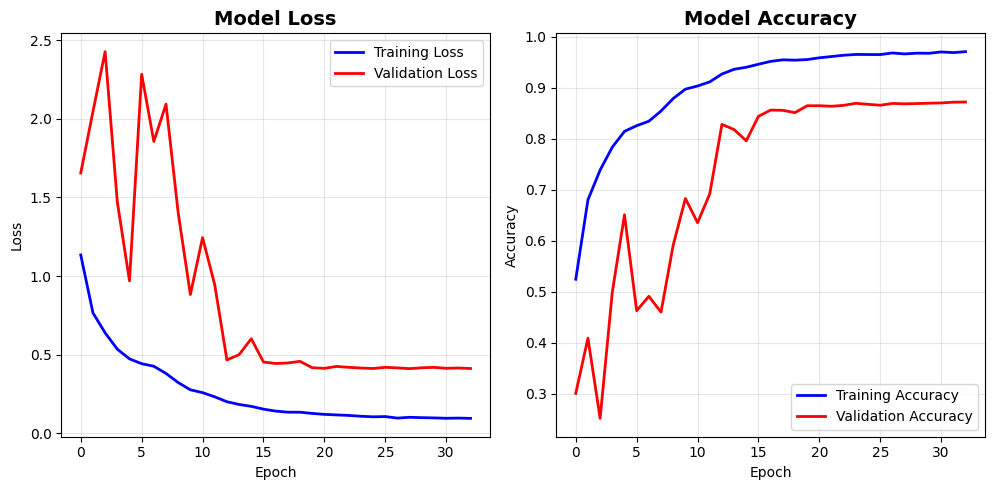

In [ ]:
if 'history' in locals():

    print("VALUTAZIONE FINALE")
    print("=" * 40)

    train_loss, train_acc = MOD5A.evaluate(train_ds, verbose=0)
    val_loss, val_acc = MOD5A.evaluate(val_ds, verbose=0)

    print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


<Figure size 600x600 with 0 Axes>

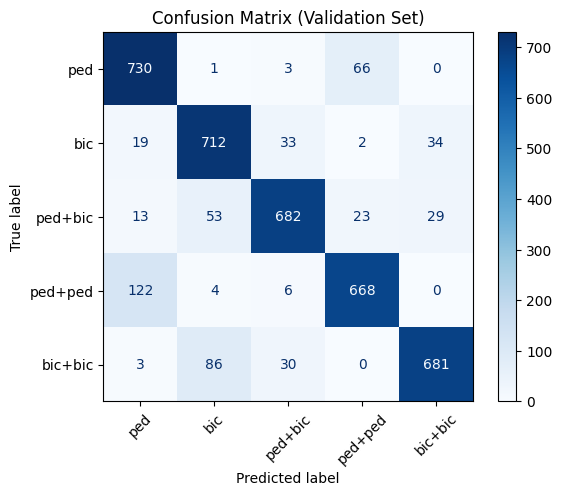

In [ ]:
y_pred_prob = MOD5A.predict(val_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

The accuracy slightly increases from original MOD5 to MOD5A with data augmentation, so we'll evaluate test set on the model trained with augmented data.

<a name="test-set"></a>
# Test Set

In [ ]:
X_test = np.load('/content/drive/MyDrive/ESAMI/Deep learning/PROGETTO/test_radar_data.npy', mmap_mode='r')
y_test = np.load('/content/drive/MyDrive/ESAMI/Deep learning/PROGETTO/test_radar_labels.npy', mmap_mode='r')

NameError: name 'np' is not defined

In [ ]:
y_cat_test = to_categorical(y_test - 1 , num_classes=5)

In [ ]:
radar_tensor = tf.expand_dims(X_test, -1)

resized = tf.image.resize(radar_tensor, (72, 200), method='area')

X_test_d = tf.squeeze(resized, axis=-1).numpy().astype(np.float32)


In [ ]:
X_test_d.shape

(5000, 72, 200)

In [ ]:
X_test_proc = tf.expand_dims(X_test_d, -1)
X_test_proc = tf.cast(X_test_proc, tf.float32)

In [ ]:
evaluation_test = MOD5A.evaluate(X_test_proc,y_cat_test)
print(f'Test accuracy : {evaluation_test[1] * 100:.2f}%')

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8662 - loss: 0.4079
Test accuracy : 86.22%
